# Imports

In [1]:
!pip install umap-learn

In [2]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

device = "cuda"

# Helper Functions

In [3]:
def unnormalize(x):
    """
    x: tensor of shape (B,3,H,W) or (3,H,W), CLIP-normalized.
    Returns: unnormalized image in [0,1].
    """
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073],
                        device=x.device)[None, :, None, None]
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711],
                        device=x.device)[None, :, None, None]

    # If x is (3,H,W), add batch dimension
    if x.dim() == 3:
        x = x.unsqueeze(0)

    x_unnorm = x * std + mean
    return x_unnorm.clamp(0, 1)

def layer_norm(x):
    ln = nn.LayerNorm(768, elementwise_affine=False).to(device)
    return ln(x)

def show_image(x):
    """
    x: torch tensor of shape (1, 3, H, W) or (3, H, W), values in [0,1]
    """
    if x.ndim == 4:
        x = x[0]  # remove batch

    x = x.detach().cpu().clamp(0, 1)

    # Convert CHW → HWC
    img = x.permute(1, 2, 0).numpy()

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


def extract_mean_vec(sample, feat_name): # for image level vectors
    h = sample["meta"][feat_name].squeeze(0)   # (seq_len, hidden_dim)
    return h.mean(axis=0).numpy()              # (hidden_dim,)

def collect_by_label(dataset, feat_name): # label -> list of mean vectors
    label_dict = {i: [] for i in range(10)}

    for sample in dataset:
        label = int(sample["label"])
        vec = extract_mean_vec(sample, feat_name)
        label_dict[label].append(vec)

    # convert to arrays
    for k in label_dict:
        if len(label_dict[k]) > 0:
            label_dict[k] = np.vstack(label_dict[k])
        else:
            label_dict[k] = None
    return label_dict

def centroid(vecs): # mean of a (N, hidden_dim) array
    if vecs is None:
        return None
    return vecs.mean(axis=0)


# Analysis

## Analysis dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
my_dataset = "eval_dataset_25.pt"
eval_dataset = dataset = torch.load(f"/content/drive/MyDrive/deep_learning/eval_datasets/{my_dataset}", map_location="cpu")

In [6]:
features = [1064, 2420, 2642, 5167, 6847, 7636, 8709, 9028, 10216, 13978, 16979,19030, 20359, 21971, 24248, 25461, 25989, 29216, 29390, 31041, 40471,43948, 44551, 47241]

feature_to_index = {f: i for i, f in enumerate(features)}

## Feature interpretations (bugged tf out)



In [14]:
# qualify SAE features semantically: find image that maximally activates a given feature

# this function does not work

import torch
import torch.nn.functional as F

def max_image(
    feature_id,
    classifier,
    sae_model,
    input='none',
    steps=100,
    lr=0.05,
    device="cuda"
):
    """
    Gradient-ascent on image x so that:
        classifier(x) -> h
        sae_model.encode(h) -> z
    and we maximize z[feature_id].

    classifier: neural net mapping image -> representation h
    sae_model: sparse autoencoder with .encode(h) -> z (latent features)
    """

    if input == 'none':
        x = torch.rand(1, 3, 32, 32, device=device, requires_grad=True)

        mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device)[None, :, None, None]
        std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device)[None, :, None, None]

        x_big = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x_norm = (x_big - mean) / std

    else:
        x = input.to(device)
        x_norm = x

    optimizer = torch.optim.Adam([x_norm], lr=lr)


    for _ in range(steps):
        optimizer.zero_grad()

        h = classifier.head(x_norm)
        z = sae_model.encode(layer_norm(h))

        activation = z[0, :, feature_id].sum()

        loss = -activation
        loss.backward()
        optimizer.step()


    x_final = x.detach()
    x_final = x - x_final.min()
    x_final = x_final / (x_final.max() + 1e-8)

    return x_final

## Analysis on selected features

### Global PCA

In [16]:
from sklearn.decomposition import PCA
import numpy as np

def plot_pca_all_labels(dataset, perturb_type, seq_len=50):
    """
    Runs PCA for labels 0–9 and plots them into a 2×5 subplot grid.
    Each subplot visualizes the PCA of clean vs perturbed tokens.
    """

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    # compute global PCA ranges
    all_points = []

    pca_inputs = []

    for label in range(10):
        label_h = []
        label_h_adv = []

        for sample in dataset:
            if sample["label"] != label:
                continue

            h = sample['meta']['h_features'].squeeze(0).numpy()
            h_adv = sample['meta'][perturb_type].squeeze(0).numpy()

            label_h.append(h)
            label_h_adv.append(h_adv)

        if not label_h:
            continue

        H = np.vstack(label_h)  # shape (N_tokens, hidden_dim)
        H_adv = np.vstack(label_h_adv)

        X = np.vstack([H, H_adv])
        pca_inputs.append(X)

    X_global = np.vstack(pca_inputs)
    pca = PCA(n_components=2)
    X_global_2d = pca.fit_transform(X_global)

    print("PC1 direction:", pca.components_[0])
    print("PC2 direction:", pca.components_[1])


    # plot per-label in subplots from global PCA
    offset = 0   # offset into X_global_2d

    for label in range(10):
        ax = axes[label]

        label_h = []
        label_h_adv = []

        for sample in dataset:
            if sample["label"] != label:
                continue

            h = sample['meta']['h_features'].squeeze(0).numpy()
            h_adv = sample['meta'][perturb_type].squeeze(0).numpy()

            label_h.append(h)
            label_h_adv.append(h_adv)

        if not label_h:
            ax.set_title(f"Label {label} (no samples)")
            ax.axis("off")
            continue

        H = np.vstack(label_h)
        H_adv = np.vstack(label_h_adv)

        n = len(H)  # number of clean samples for this label

        # extract the relevant portion of globally PCA'ed coordinates
        X2D = X_global_2d[offset : offset + 2*n]
        offset += 2 * n

        H2D = X2D[:n]
        H_adv2D = X2D[n:]

        ax.scatter(H2D[:, 0], H2D[:, 1], alpha=0.5, color='blue', s=10)
        ax.scatter(H_adv2D[:, 0], H_adv2D[:, 1], alpha=0.5, color='red', s=10)

        ax.set_title(f"Label {label}")
        ax.grid(True)
        ax.set_aspect('equal')

    fig.suptitle(f"PCA of Hidden Tokens for All Labels (perturb={perturb_type})", fontsize=18)
    plt.tight_layout()
    plt.show()


PC1 direction: [-0.25730413 -0.00488284  0.09261867  0.29575703 -0.07257044  0.08792919
 -0.00776279  0.44726065  0.09016392  0.10147903 -0.12105912  0.23926395
  0.3811967   0.20571478  0.29351607 -0.03518921 -0.07760884  0.23345925
  0.03066189  0.21045737  0.02507812  0.33714724  0.10068632  0.17051883]
PC2 direction: [ 0.38164195  0.0128146   0.00839544  0.28448984  0.18162976 -0.1596977
  0.00894057  0.00706491 -0.17642209 -0.31172553  0.15327284  0.30871522
  0.06411062  0.36533374  0.22681808  0.00607581  0.19971979 -0.2879575
 -0.12409613  0.05260448 -0.17692634 -0.00097066 -0.00476619 -0.32572845]


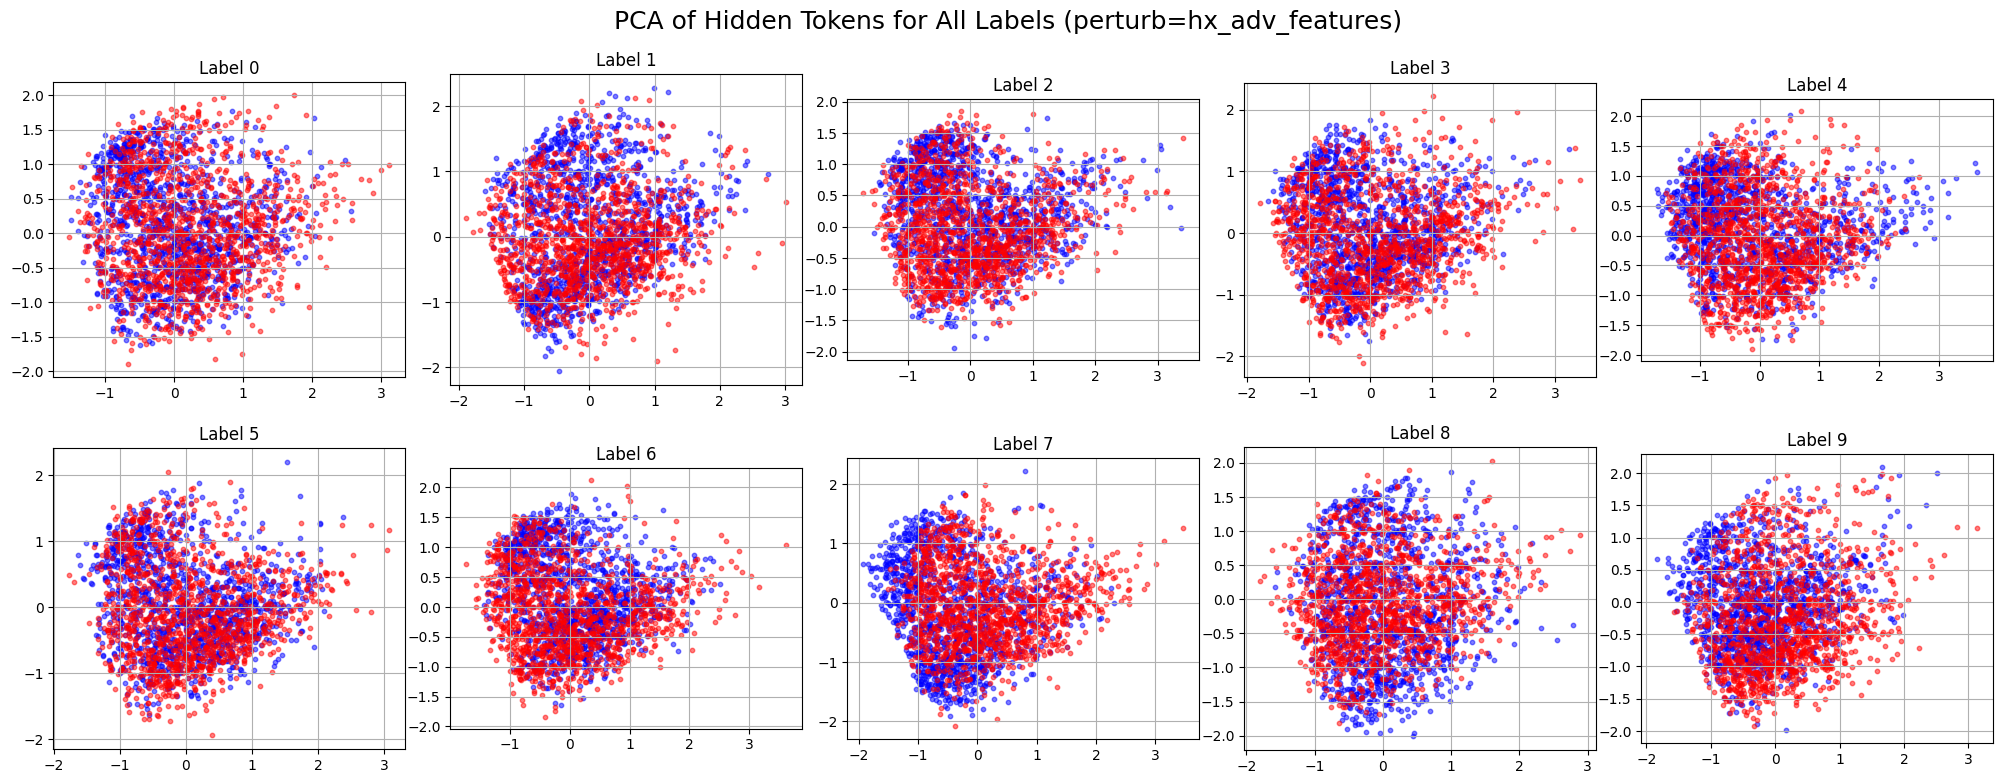

In [17]:
plot_pca_all_labels(eval_dataset, perturb_type="hx_adv_features")

### Clean PCA

In [7]:
from sklearn.decomposition import PCA

def plot_pca_clean_reference(dataset, perturb_type, seq_len=50):
    """
    Computes PCA only from CLEAN activations (labels 0–9),
    then projects BOTH clean and adversarial activations into
    that same PCA space. Plots each label in a 2×5 grid.
    """

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    clean_inputs = []
    clean_adv_pairs = []    # to keep (clean, adv) in order per label

    # gather clean activations for global PCA
    for label in range(10):
        label_clean = []
        label_adv = []

        for sample in dataset:
            if sample["label"] != label:
                continue

            h = sample['meta']['h_features'].squeeze(0).numpy()
            h_adv = sample['meta'][perturb_type].squeeze(0).numpy()

            label_clean.append(h)
            label_adv.append(h_adv)

        if not label_clean:
            clean_adv_pairs.append(None)
            continue

        H = np.vstack(label_clean)         # clean only
        H_adv = np.vstack(label_adv)       # adversarial for that label
        clean_inputs.append(H)
        clean_adv_pairs.append((H, H_adv))

    # fit PCA  on clean activations
    X_clean_global = np.vstack(clean_inputs)
    pca = PCA(n_components=2)
    X_clean_global_2d = pca.fit_transform(X_clean_global)

    print("PC1 (from clean data):", pca.components_[0])
    print("PC2 (from clean data):", pca.components_[1])

    # prepare projection for adversarial later
    offset = 0

    # plot label-by-label using clean-only PCA
    for label in range(10):
        ax = axes[label]

        pair = clean_adv_pairs[label]
        if pair is None:
            ax.set_title(f"Label {label} (no samples)")
            ax.axis("off")
            continue

        H, H_adv = pair
        n = len(H)

        # pxtract the corresponding clean projections from the PCA output
        H2D = X_clean_global_2d[offset : offset + n]
        offset += n

        # project adversarial using the SAME PCA transform
        H_adv2D = pca.transform(H_adv)

        # plot
        ax.scatter(H2D[:, 0], H2D[:, 1], alpha=0.5, color='blue', s=10, label="clean")
        ax.scatter(H_adv2D[:, 0], H_adv2D[:, 1], alpha=0.5, color='red', s=10, label="adv")

        ax.set_title(f"Label {label}")
        ax.grid(True)
        ax.set_aspect('equal')

    fig.suptitle(f"PCA of Hidden Tokens (clean PCA basis, perturb={perturb_type})", fontsize=18)
    plt.tight_layout()
    plt.show()

PC1 (from clean data): [ 0.4088726   0.01576076 -0.09443528 -0.15735169  0.13589688 -0.16522
 -0.01098652 -0.40202352 -0.19093314 -0.21308999  0.18218072 -0.09359304
 -0.32223454 -0.03792915 -0.1597165   0.01251047  0.15485823 -0.3362623
 -0.06265952 -0.12845783 -0.08792782 -0.28028604 -0.12788834 -0.27660093]
PC2 (from clean data): [ 0.20037031  0.02032769  0.05324512  0.36427462  0.12103343 -0.12917484
 -0.00411543  0.20308389 -0.12150586 -0.26046842  0.06457995  0.37817797
  0.21793342  0.42652634  0.33324564 -0.04308495  0.13319795 -0.15295534
 -0.12122921  0.10722329 -0.17674664  0.13323678  0.03056798 -0.24885897]


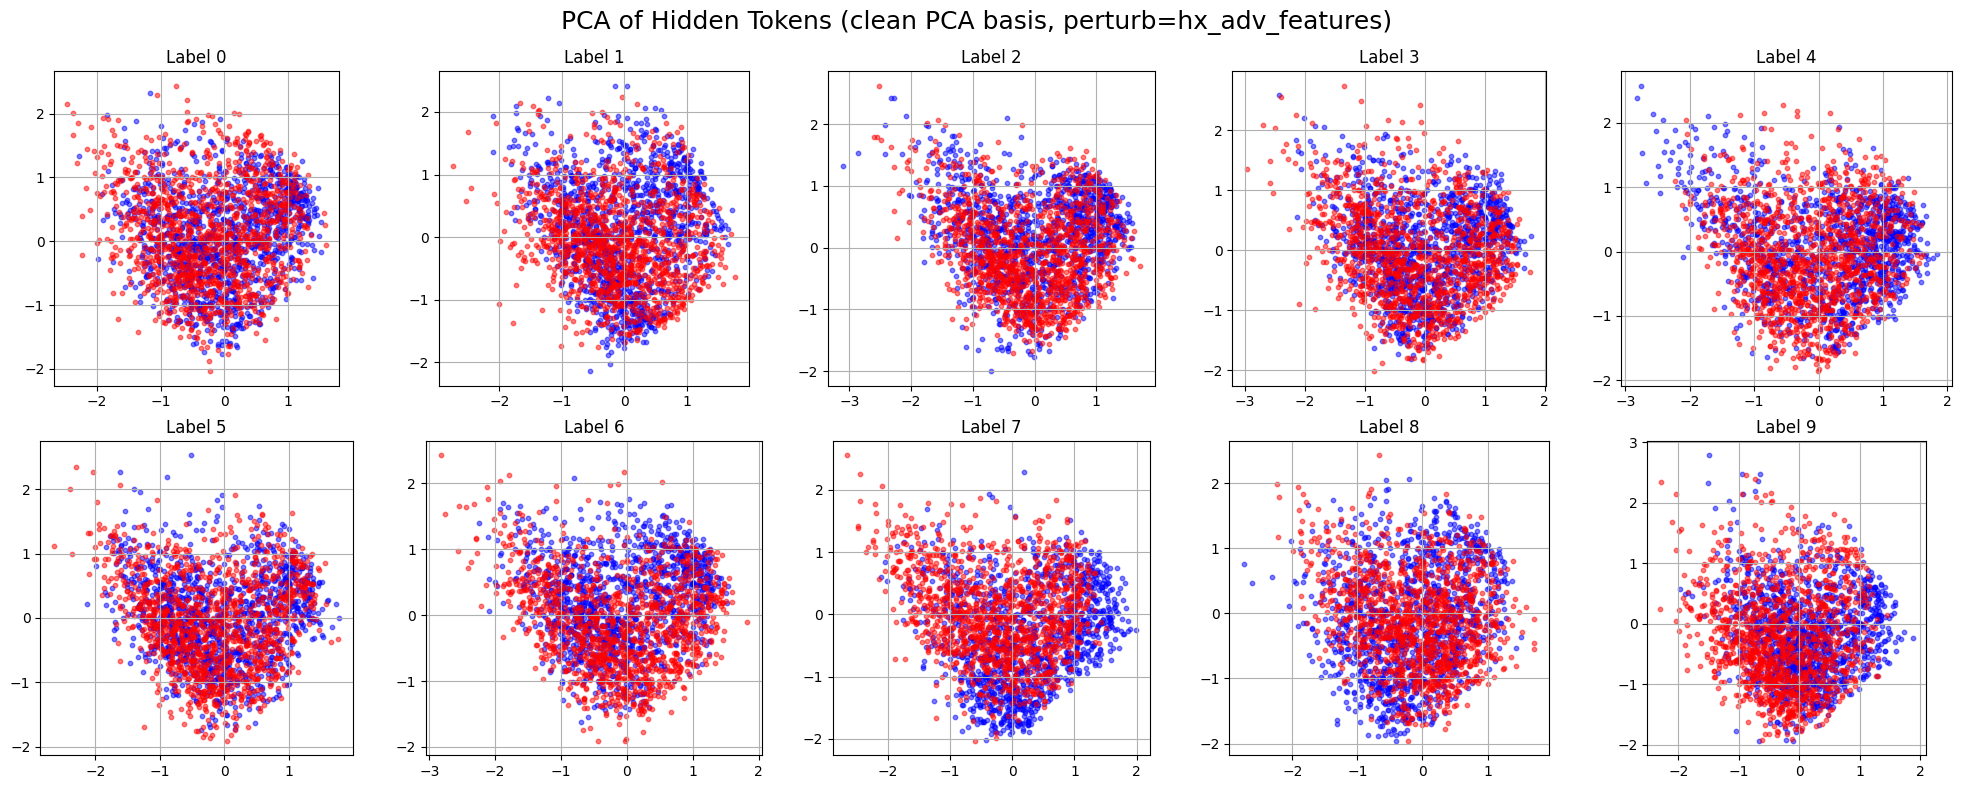

In [8]:
plot_pca_clean_reference(
    dataset=eval_dataset,
    perturb_type="hx_adv_features",
)

### UMAP

In [18]:
import umap

def extract_vectors(dataset, feat_name, mode="cls"):
    """
    Extract one vector per image using either:
      - mode='cls' : CLS token only
      - mode='mean': mean over all tokens
    """
    vecs = []
    labels = []

    for sample in dataset:
        h = sample['meta'][feat_name].squeeze(0)  # shape: (seq_len, hidden_dim)

        if mode == "cls":
            vec = h[0]    # CLS token
        elif mode == "mean":
            vec = h.mean(axis=0)
        else:
            raise ValueError(f"Unknown mode '{mode}'. Use 'cls' or 'mean'.")

        vecs.append(vec.numpy())
        labels.append(sample["label"])

    return np.vstack(vecs), np.array(labels)


def umap_subplots_clean_adv_hx_adv(dataset, adv_name="h_adv_features", hx_adv_name="hx_adv_features", mode="cls"):
    """
    Produces a 1x3 subplot of:
      Clean only
      Clean vs Adversarial
      Clean vs Input Adversarial
    Shared UMAP space.
    mode = 'cls' or 'mean'
    """

    clean_vecs, labels = extract_vectors(dataset, "h_features", mode=mode)
    adv_vecs, _        = extract_vectors(dataset, adv_name, mode=mode)
    hx_adv_vecs, _        = extract_vectors(dataset, hx_adv_name, mode=mode)

    # combined matrix for global UMAP
    X_all = np.vstack([clean_vecs, adv_vecs, hx_adv_vecs])

    # UNO umap
    reducer = umap.UMAP(
        n_neighbors=20,
        min_dist=0.1,
        metric="cosine",
        random_state=42
    )

    X_emb = reducer.fit_transform(X_all)

    N = len(clean_vecs)
    clean_emb = X_emb[:N]
    adv_emb   = X_emb[N:2*N]
    hx_adv_emb   = X_emb[2*N:3*N]

    # color by label
    cmap = plt.cm.tab10
    lbl_colors = cmap(labels / labels.max())

    # plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    title_suffix = "(CLS token)" if mode == "cls" else "(Mean-pooled tokens)"

    # lean only
    ax = axes[0]
    ax.scatter(clean_emb[:,0], clean_emb[:,1], c=lbl_colors, s=25, alpha=0.8)
    ax.set_title(f"Clean Embeddings {title_suffix}")
    ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
    ax.grid(True)

    # clean vs adversarial
    ax = axes[1]
    ax.scatter(clean_emb[:,0], clean_emb[:,1], c=lbl_colors, s=25, alpha=0.4, label="Clean")
    ax.scatter(adv_emb[:,0],   adv_emb[:,1],   c=lbl_colors, s=25, alpha=0.8, marker="x", label="Adv")
    ax.set_title(f"Clean vs H_adv {title_suffix}")
    ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
    ax.legend()
    ax.grid(True)

    # clean vs input adversarial
    ax = axes[2]
    ax.scatter(clean_emb[:,0], clean_emb[:,1], c=lbl_colors, s=25, alpha=0.4, label="Clean")
    ax.scatter(hx_adv_emb[:,0],   hx_adv_emb[:,1],   c=lbl_colors, s=35, alpha=0.8, marker="*", label="H(x_adv)")
    ax.set_title(f"Clean vs H(x_adv) {title_suffix}")
    ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


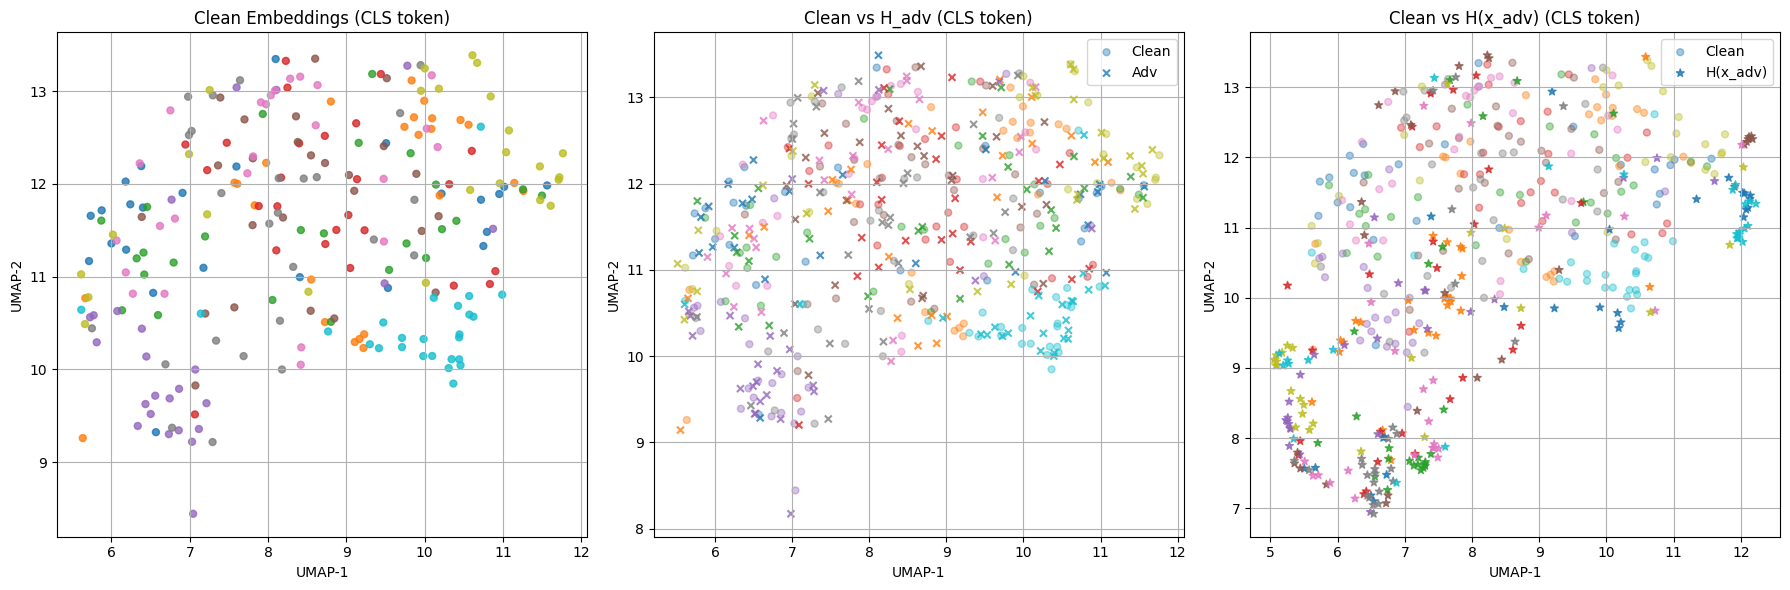

In [19]:
umap_subplots_clean_adv_hx_adv(eval_dataset,
                            adv_name="h_adv_features",
                            hx_adv_name="hx_adv_features")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


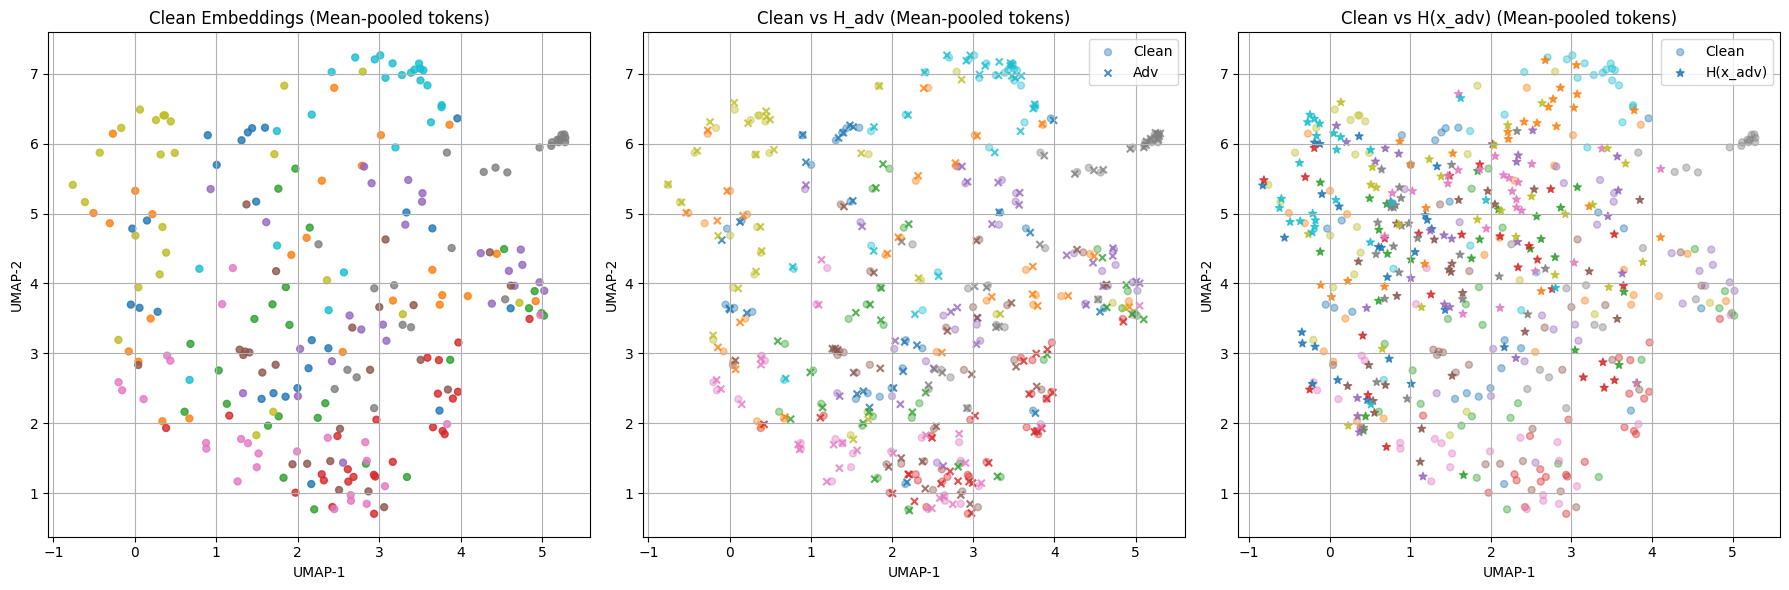

In [20]:
umap_subplots_clean_adv_hx_adv(eval_dataset,
                            adv_name="h_adv_features",
                            hx_adv_name="hx_adv_features", mode="mean")

###Non-manifold

### Cosine similarity heatmaps

In [23]:
def plot_class_centroid_drift(dataset, adv_name="h_adv_features", hx_adv_name="hx_adv_features"):
    # collect vectors per label
    clean = collect_by_label(dataset, "h_features")
    adv   = collect_by_label(dataset, adv_name)
    hx_adv   = collect_by_label(dataset, hx_adv_name)

    # compute centroids
    clean_c = []
    adv_c   = []
    hx_adv_c   = []
    labels  = []

    for lbl in range(10):
        if clean[lbl] is None:
            continue

        clean_c.append(centroid(clean[lbl]))
        adv_c.append(centroid(adv[lbl]))
        hx_adv_c.append(centroid(hx_adv[lbl]))
        labels.append(lbl)

    clean_c = np.vstack(clean_c)
    adv_c   = np.vstack(adv_c)
    hx_adv_c   = np.vstack(hx_adv_c)

    pca = PCA(n_components=2)
    clean_2d = pca.fit_transform(clean_c)
    adv_2d   = pca.transform(adv_c)
    hx_adv_2d   = pca.transform(hx_adv_c)

    # plot
    plt.figure(figsize=(10,7))
    for i,lbl in enumerate(labels):
        # clean point
        plt.scatter(clean_2d[i,0], clean_2d[i,1], color="blue")
        # adv arrow
        plt.arrow(clean_2d[i,0], clean_2d[i,1],
                  adv_2d[i,0]-clean_2d[i,0],
                  adv_2d[i,1]-clean_2d[i,1],
                  color="red", head_width=0.005)
        # hx_adv arrow
        plt.arrow(adv_2d[i,0], adv_2d[i,1],
                  hx_adv_2d[i,0]-adv_2d[i,0],
                  hx_adv_2d[i,1]-adv_2d[i,1],
                  color="green", head_width=0.005)
        plt.text(clean_2d[i,0], clean_2d[i,1], str(lbl))

    plt.title("Class centroid drift: clean → adv → hx_adv")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

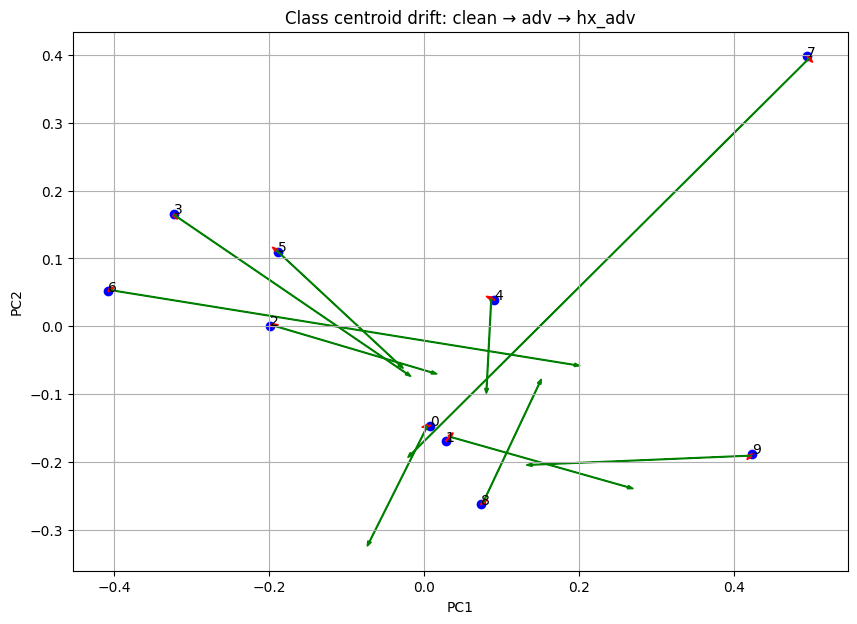

In [24]:
plot_class_centroid_drift(eval_dataset)

### Pariwise trajectory

In [25]:
def plot_class_pairwise_trajectories(dataset, adv_name="h_adv_features", hx_adv_name="hx_adv_features"):
    clean = collect_by_label(dataset, "h_features")
    adv   = collect_by_label(dataset, adv_name)
    hx_adv   = collect_by_label(dataset, hx_adv_name)

    clean_cent = np.vstack([centroid(clean[i]) for i in range(10)])
    adv_cent   = np.vstack([centroid(adv[i])   for i in range(10)])
    hx_adv_cent   = np.vstack([centroid(hx_adv[i])   for i in range(10)])

    pca = PCA(n_components=2)
    clean_2d = pca.fit_transform(clean_cent)
    adv_2d   = pca.transform(adv_cent)
    hx_adv_2d   = pca.transform(hx_adv_cent)

    plt.figure(figsize=(10,10))
    for i in range(10):
        for j in range(i+1,10):
            # draw class-to-class lines for clean
            plt.plot([clean_2d[i,0], clean_2d[j,0]],
                     [clean_2d[i,1], clean_2d[j,1]],
                     color="blue", alpha=0.3)

            # adv
            plt.plot([adv_2d[i,0], adv_2d[j,0]],
                     [adv_2d[i,1], adv_2d[j,1]],
                     color="red", alpha=0.3)

            # hx_adv
            plt.plot([hx_adv_2d[i,0], hx_adv_2d[j,0]],
                     [hx_adv_2d[i,1], hx_adv_2d[j,1]],
                     color="green", alpha=0.3)

    plt.title("Pairwise class trajectories (clean vs adv vs hx_adv)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.grid(True); plt.show()

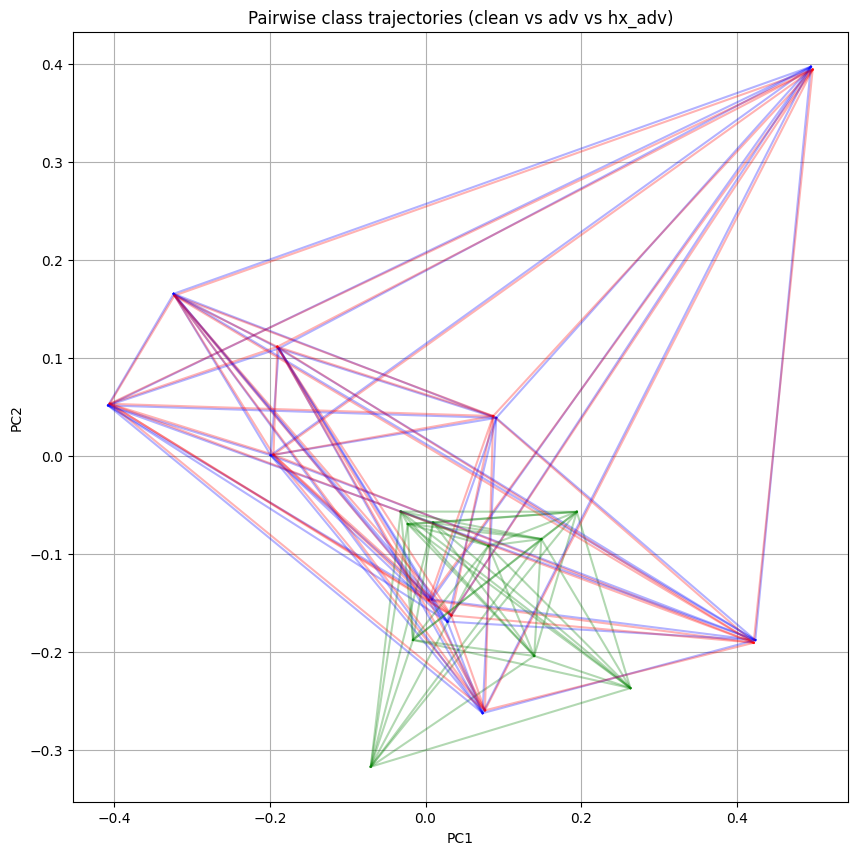

In [26]:
plot_class_pairwise_trajectories(eval_dataset)

### Token-level drift heatmap

In [27]:
def plot_token_drift_heatmap(dataset, features, adv_name="h_adv_features", mode="mean"):
    diffs = []
    row_labels = []

    for idx, sample in enumerate(dataset):
        h = sample["meta"]["h_features"].squeeze(0)        # shape (T, D)
        h_adv = sample["meta"][adv_name].squeeze(0)

        if mode == "cls":
            diff = h_adv[0] - h[0]

        elif mode == "mean":
            diff = (h_adv - h).mean(axis=0)

        else:
            raise ValueError("mode must be 'cls' or 'mean'")

        diffs.append(diff.numpy())

        # Add y-axis label
        lbl = sample["label"]
        row_labels.append(f"({idx}, {lbl})")

    diffs = np.vstack(diffs)  # shape (N_images, D)

    feature_labels = [str(f) for f in features]

    plt.figure(figsize=(14, 7))

    sns.heatmap(
        diffs,
        cmap="coolwarm",
        center=0,
        xticklabels=feature_labels,
        yticklabels=row_labels
    )

    title_suffix = "CLS Token" if mode == "cls" else "Mean Over Tokens"
    plt.title(f"Hidden-Dimension Drift per Feature (adv - clean) [{title_suffix}]")
    plt.xlabel("Feature ID")
    plt.ylabel("Image (index, label)")

    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.show()

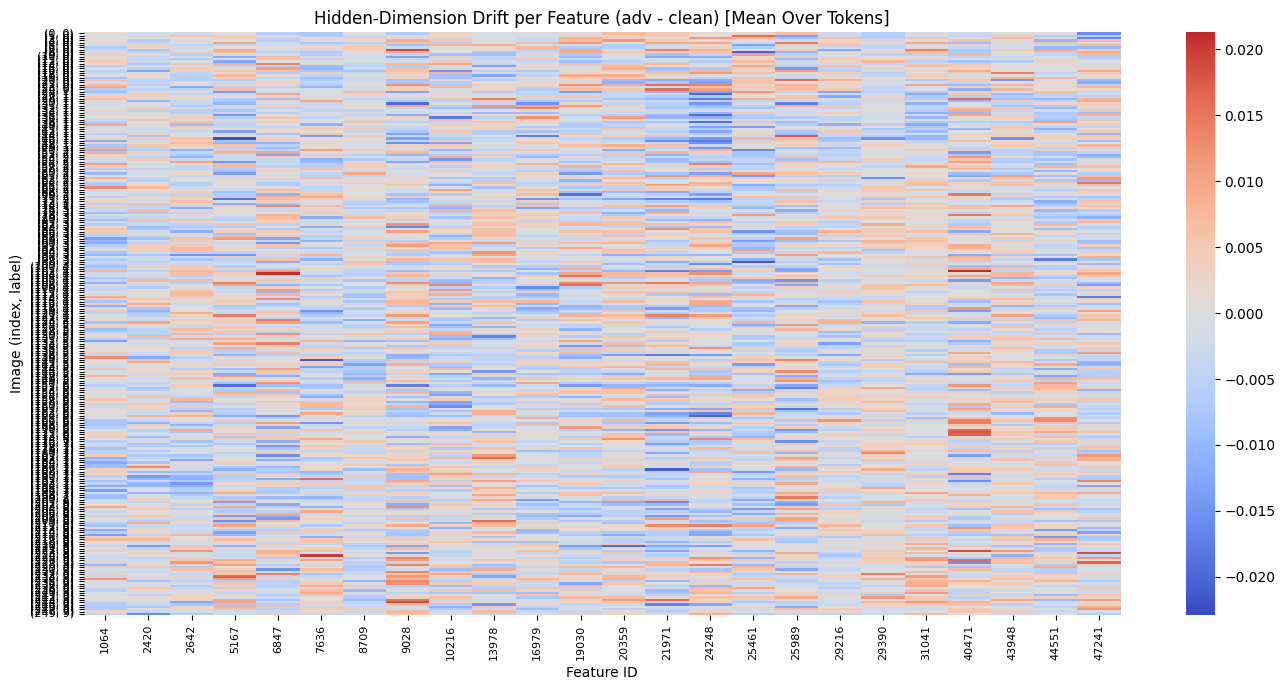

In [28]:
plot_token_drift_heatmap(eval_dataset, features)

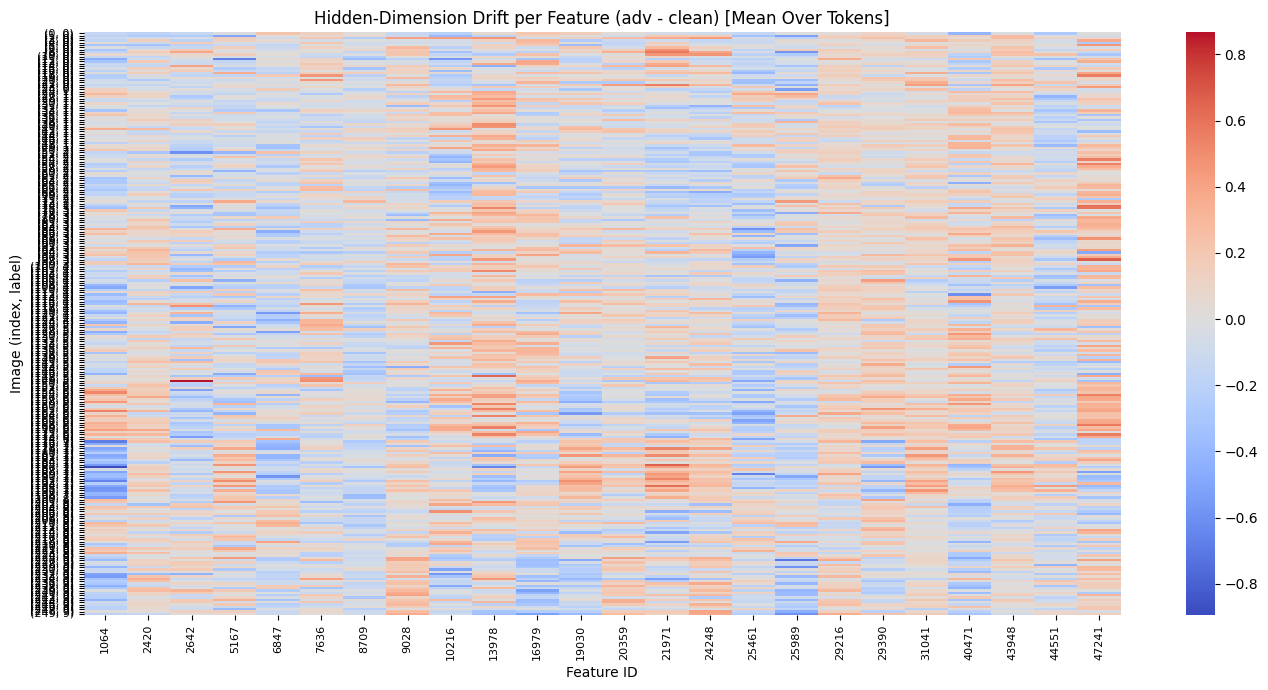

In [29]:
plot_token_drift_heatmap(eval_dataset, features, adv_name="hx_adv_features")

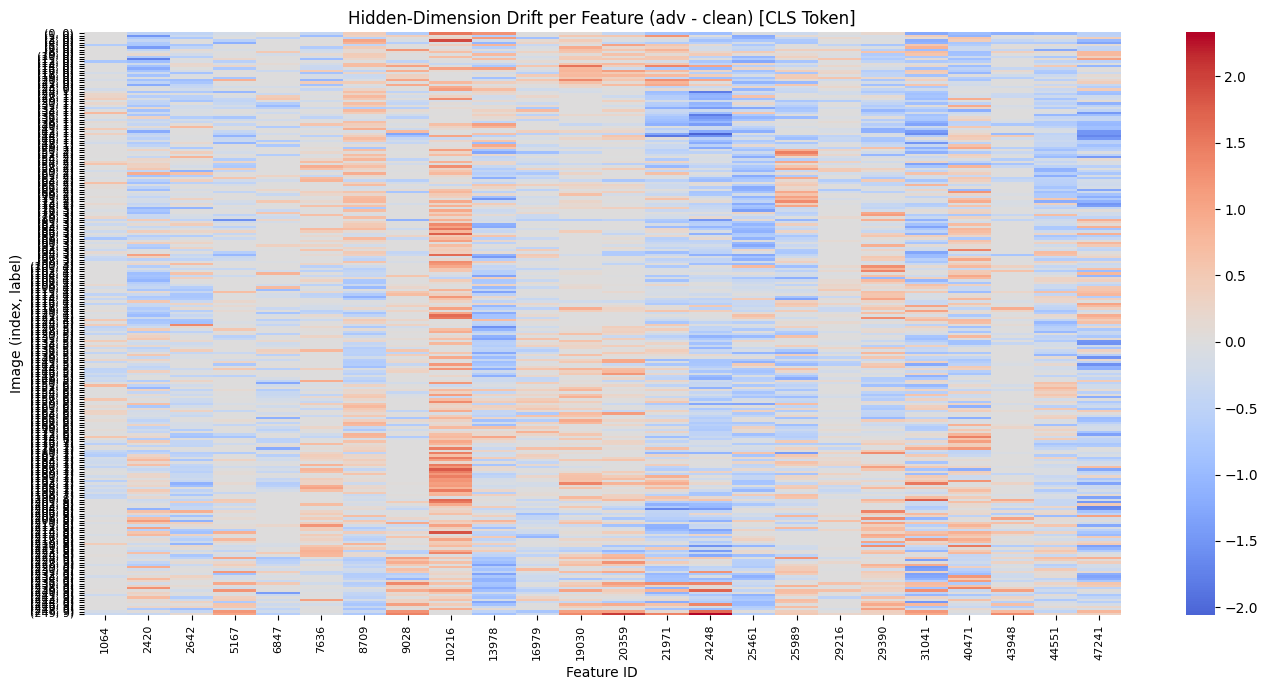

In [30]:
plot_token_drift_heatmap(eval_dataset, features, adv_name="hx_adv_features", mode="cls")

### Perturbation fingerprint radar

In [31]:
def plot_perturbation_fingerprint(dataset, adv_name="hx_adv_features"):
    clean = collect_by_label(dataset, "h_features")
    adv   = collect_by_label(dataset, adv_name)

    clean_cent = {i: centroid(clean[i]) for i in range(10)}
    adv_cent   = {i: centroid(adv[i])   for i in range(10)}

    plt.figure(figsize=(10,10))
    ax = plt.subplot(111, polar=True)

    for lbl in range(10):
        vec = adv_cent[lbl] - clean_cent[lbl]
        # angle of movement
        angle = np.arctan2(vec[1], vec[0])
        # magnitude
        mag = np.linalg.norm(vec)

        ax.scatter(angle, mag, label=f"Class {lbl}")

    ax.set_title("Perturbation fingerprint (direction + magnitude per class)")
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
    plt.show()

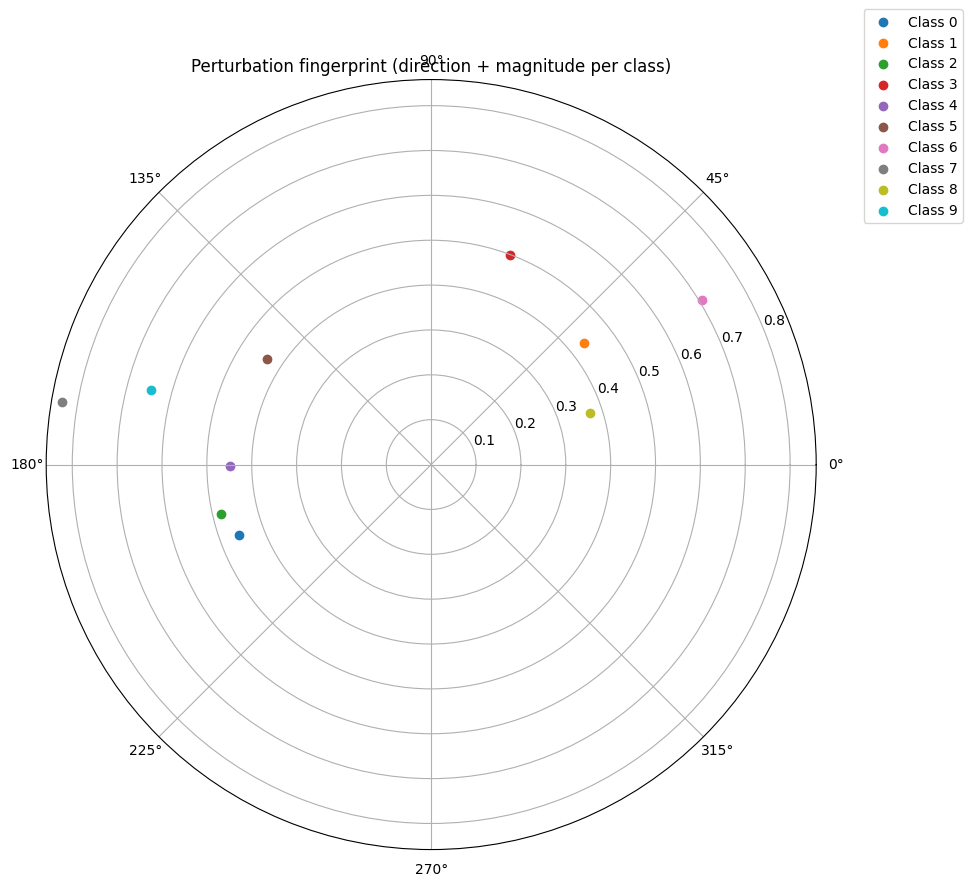

In [32]:
plot_perturbation_fingerprint(eval_dataset)